In [1]:
# Reading from full dataset (Method 1)
# import time
# import dask.dataframe as dd
# import numpy as np
# import pandas as pd
# from datetime import datetime
# dateparse = lambda x1, x2: datetime.strptime(x1+" "+x2, '%Y-%m-%d %H:%M')
# df = dd.read_csv('./dataset/pm25/pm25_hourly_shard*.csv', dtype={'sample_measurement': 'float64', 'mdl': 'float64'}, parse_dates={'datetime_gmt': ['date_gmt', 'time_gmt']}, date_parser=dateparse)
# df = df.compute()
# df_copy = df.copy()

/opt/homebrew/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


In [2]:
# Reading from full dataset (Method 2)
# import pandas as pd
# import glob
# import functools
# df2 = pd.concat(map(functools.partial(pd.read_csv, sep='|', compression=None), glob.glob("dataset/pm25/PM2.5_Hourly_Shard_*.csv")))

In [19]:
# Reading from a subset of dataset
import numpy as np
import pandas as pd
from datetime import datetime

# Method 1 - TypeError
dateparse = lambda x1: datetime.strptime(x1, '%Y-%m-%d %H:%M')
df = pd.read_csv('./dataset/pm25_small.csv', parse_dates={'datetime_gmt': ['date_gmt', 'time_gmt']}, date_parser=dateparse)
df_copy = df.copy()

# Method 2 - ValueError, cannot convert string to float
# df = pd.read_csv('./dataset/pm25_small.csv')

# Method 3 - TypeError
# dateparse = lambda date, time: [datetime.strptime(x1[0]+" "+x1[1], '%Y-%m-%d %H:%M') for x1 in zip(date,time)]
# df = pd.read_csv('./dataset/pm25_small.csv', parse_dates={'datetime_gmt': ['date_gmt', 'time_gmt']}, date_parser=dateparse)

# Method 4 - TypeError
# def dateparse(d,t):
#     dt = d + " " + t
#     return pd.datetime.strptime(dt, '%Y-%m-%d %H:%M')
# df = pd.read_csv('./dataset/pm25_small.csv', parse_dates={'datetime_gmt': ['date_gmt', 'time_gmt']}, date_parser=dateparse)


In [20]:
# Preprocessing Method 1
import datetime
y = df['sample_measurement']
y = y.to_numpy()
x = df.drop(['sample_measurement'], axis = 1)
del df, df_copy

# Preprocessing Method 2
# import datetime
# y = df['sample_measurement']
# y = y.to_numpy()
# datetime_gmt_int = df_copy.apply(lambda x1: x1['datetime_gmt'].timestamp(), axis=1)
# df['datetime_gmt'] = datetime_gmt_int
# x = df.drop(['sample_measurement'], axis=1)
# del df, df_copy, datetime_gmt_int
# x_names = x.columns

In [21]:
# Feature extraction (see extract_features() in selFeat.py)
x['year'] = x['datetime_gmt'].dt.year
x['month'] = x['datetime_gmt'].dt.month
x['day'] = x['datetime_gmt'].dt.day
x['hour'] = x['datetime_gmt'].dt.hour
x = x.drop(columns = 'datetime_gmt')

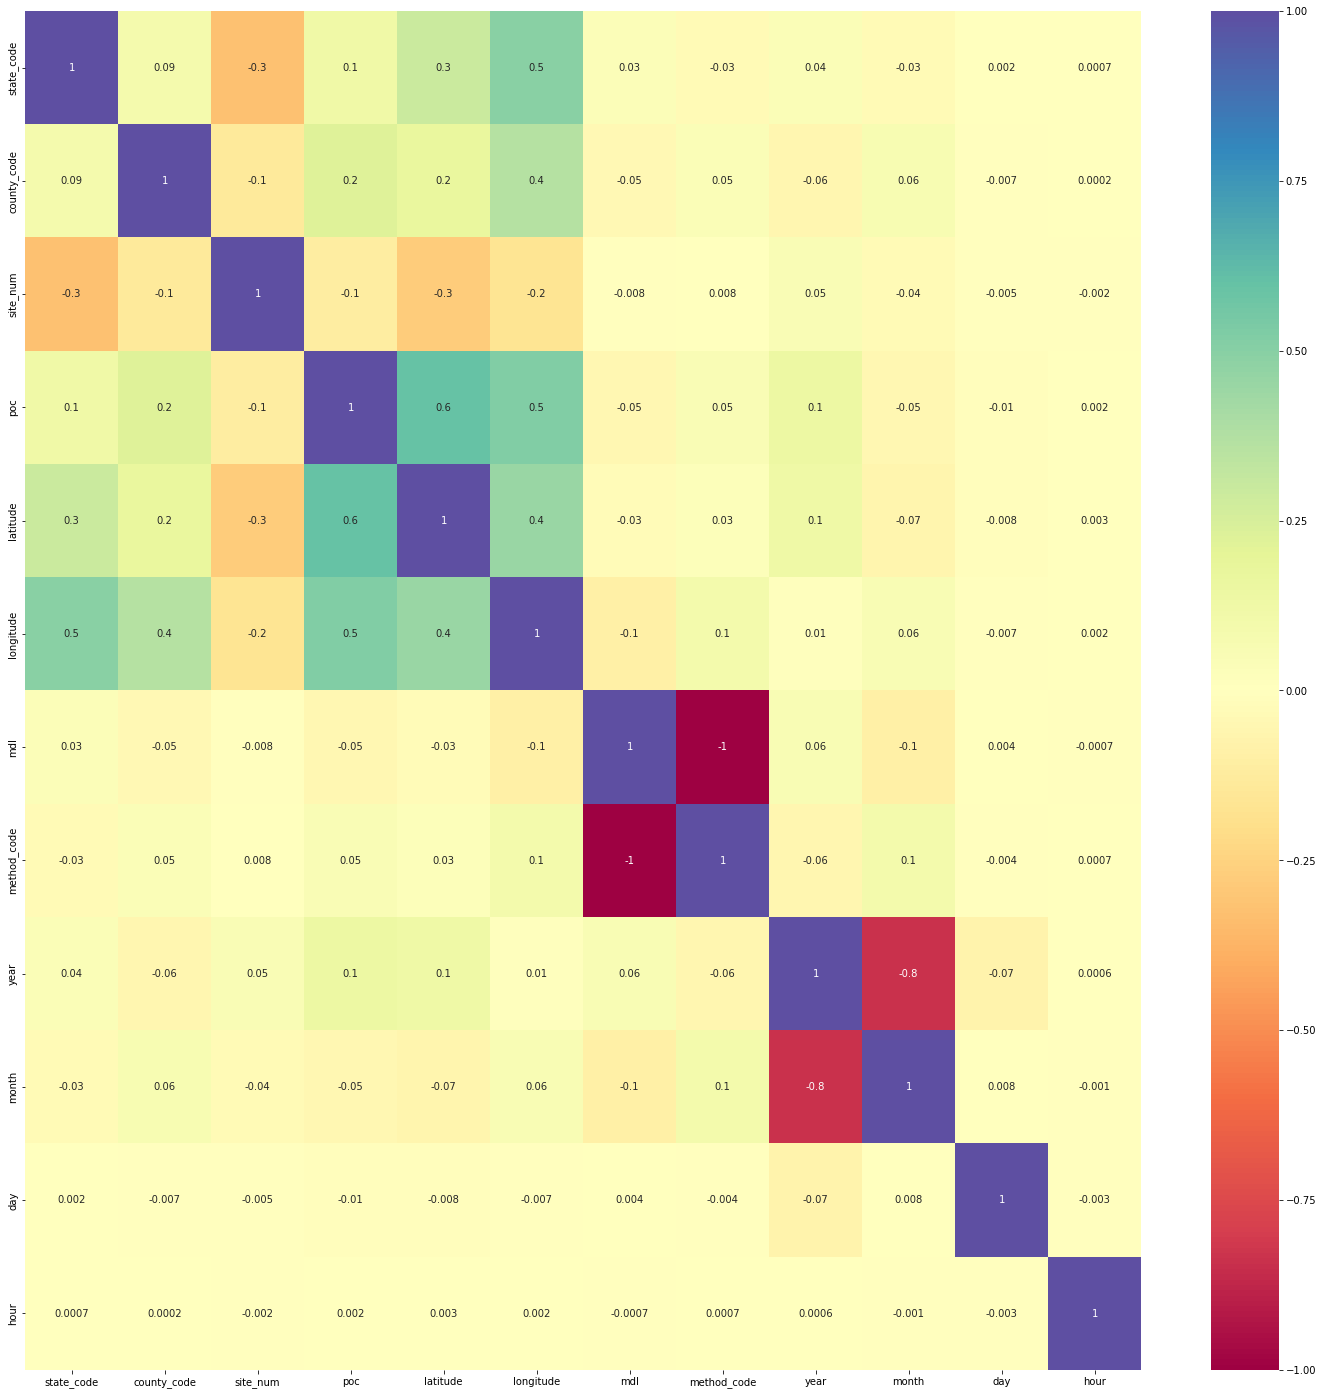

In [22]:
# Feature selection
from matplotlib import pyplot as plt
import seaborn as sns

x_corr = x.corr()
fig = plt.figure(figsize=(25, 25))
fig.patch.set(facecolor = 'white')
sns.heatmap(x_corr, ax= plt.subplot(1, 1, 1), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='Spectral')
plt.savefig('pearson_corr.png')
plt.show()
x = x.drop(columns = ['mdl', 'year'])
x_names = x.columns

In [5]:
# Train/Test split (Non-standardized and standardized)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.66, random_state=0)

# Feature standardization
from sklearn import preprocessing
x_train_std = preprocessing.StandardScaler().fit_transform(x_train)
x_test_std = preprocessing.StandardScaler().transform(x_test)
x_train_std = pd.DataFrame(x_train_std, columns=x_names)
x_test_std = pd.DataFrame(x_test_std, columns=x_names)

In [6]:
# Linear Regression
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression().fit(x_train, y_train)
yHat = reg1.predict(x_test)
from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test, yHat)}')
print(f'MSE: {metrics.mean_squared_error(y_test, yHat)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, yHat)}')
print(f'R^2: {metrics.r2_score(y_test, yHat)}\n')
# Mean Absolute Error: 4.9377971198751
# MSE: 59.5847091464 75355
# MAPE: 794026351470297.4
# R^2: 0.032651498552010216
# R^2 closer to 1 is better

Mean Absolute Error: 4.9377971198751
MSE: 59.584709146475355
MSE: 794026351470297.4
R^2: 0.032651498552010216



In [7]:
# Linear Regression with Ridge Regularization
from sklearn.linear_model import RidgeCV
reg2 = RidgeCV(alphas = [0.1, 0.5, 1, 5, 10], cv = 5, scoring = 'r2').fit(x_train, y_train)
yHat = reg2.predict(x_test)
from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test, yHat)}')
print(f'MSE: {metrics.mean_squared_error(y_test, yHat)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, yHat)}')
print(f'R^2: {metrics.r2_score(y_test, yHat)}\n')
# Mean Absolute Error: 4.937797119827383
# MSE: 59.5847091464 9274
# MAPE: 794026351570645.4
# R^2: 0.032651498551728

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.92758e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.92911e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.93017e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.9328e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarni

Mean Absolute Error: 4.937797119827383
MSE: 59.58470914649274
MSE: 794026351570645.4
R^2: 0.032651498551728



In [8]:
# Linear Regression (Standardized)
from sklearn.linear_model import LinearRegression
reg3 = LinearRegression().fit(x_train_std, y_train)
yHat = reg3.predict(x_test_std)
from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test, yHat)}')
print(f'MSE: {metrics.mean_squared_error(y_test, yHat)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, yHat)}')
print(f'R^2: {metrics.r2_score(y_test, yHat)}\n')
# Mean Absolute Error: 4.9377971198751
# MSE: 59.584709146475355
# MAPE: 794026351470297.9
# R^2: 0.032651498552010216

Mean Absolute Error: 4.9377971198751
MSE: 59.584709146475355
MSE: 794026351470297.9
R^2: 0.032651498552010216



In [13]:
# Linear Regression with Ridge Regularization (Standardized)
from sklearn.linear_model import RidgeCV
reg4 = RidgeCV(alphas = [0.1, 0.5, 1, 5, 10], cv = 5, scoring = 'r2').fit(x_train_std, y_train)
yHat = reg4.predict(x_test_std)
from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test, yHat)}')
print(f'MSE: {metrics.mean_squared_error(y_test, yHat)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, yHat)}')
print(f'R^2: {metrics.r2_score(y_test, yHat)}\n')
# MAE: 4.937797137573696
# MSE: 59.58470914268629
# MAPE: 794026383407207.1
# R^2: 0.03265149861352501

MAE: 4.937797137573696
MSE: 59.58470914268629
MAPE: 794026383407207.1
R^2: 0.03265149861352501



In [10]:
# Cross Validation
from sklearn.model_selection import GridSearchCV


In [12]:
# Model Metrics
# from sklearn import metrics
# print(f'MSE {metrics.mean_squared_error(y, yHat)}')


-10.0
1248.9
